<a href="https://colab.research.google.com/github/yshnxd/solaris/blob/main/solaris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Libraries

In [ ]:
# Install yfinance if not already installed
!pip install yfinance --upgrade --quiet

# Import core libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For scaling before feeding to ML models
from sklearn.preprocessing import MinMaxScaler


In [ ]:
!pip install ta



# Collect Hourly Data

In [ ]:
import yfinance as yf

ticker = 'AAPL'
start_date = '2024-07-15'
end_date = '2025-07-15'  # Within the 60-day limit

data = yf.download(tickers=ticker, start=start_date, end=end_date, interval='1h')



/tmp/ipython-input-575-4265567811.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=ticker, start=start_date, end=end_date, interval='1h')
[*********************100%***********************]  1 of 1 completed


basic plot to visualize

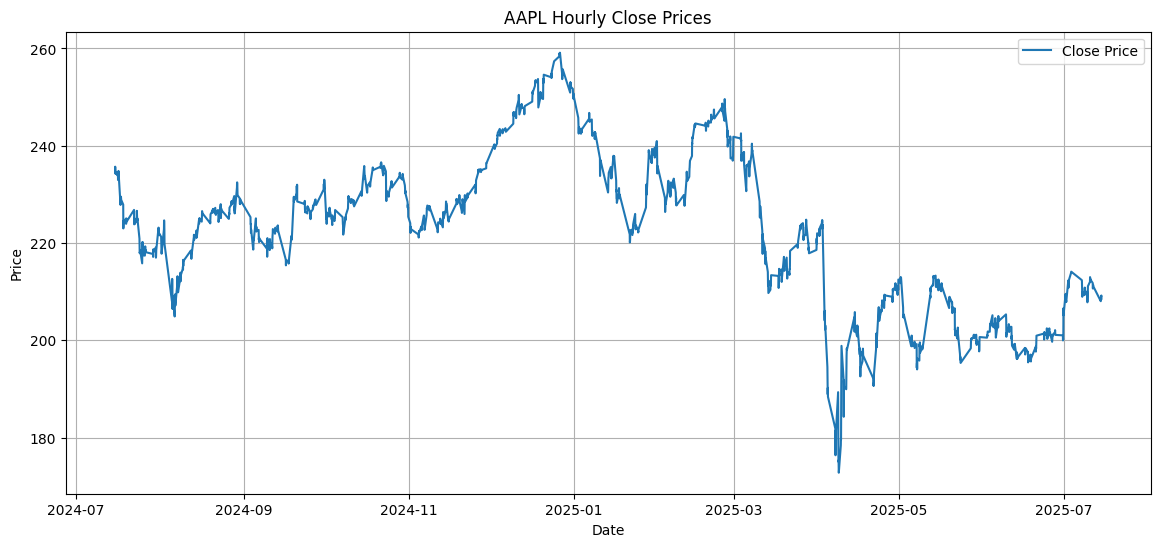

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{ticker} Hourly Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.show()


Drop duplicates

In [ ]:
data = data.copy()
data.drop_duplicates(inplace=True)

Flatten data

In [ ]:
data.columns = [col[0] if col[1] == 'AAPL' else col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in data.columns]


In [ ]:

print(data.columns)


Index(['C__', 'H__', 'L__', 'O__', 'V__'], dtype='object')


# Feature Editing

In [ ]:
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator


In [ ]:
import pandas as pd
import numpy as np

# Price returns & momentum
df['return_1h'] = df['Close'].pct_change()
df['return_3h'] = df['Close'].pct_change(3)
df['momentum'] = df['Close'] - df['Close'].shift(3)

# Trend indicators
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

# MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_hist'] = df['MACD'] - df['MACD_signal']

# Volatility
df['rolling_std_3'] = df['Close'].rolling(window=3).std()


# RSI (manual implementation)
delta = df['Close'].diff().values  # Already 1D if Close is Series

gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

# 👇 Flatten before wrapping with Series
avg_gain = pd.Series(gain.flatten()).rolling(window=14).mean()
avg_loss = pd.Series(loss.flatten()).rolling(window=14).mean()

rs = avg_gain / (avg_loss + 1e-10)  # prevent division by zero
rsi = 100 - (100 / (1 + rs))

df['RSI_manual'] = rsi


# Drop rows with NaNs from rolling windows
df = df.dropna().reset_index(drop=True)


In [ ]:
print(df.columns.tolist())


[('Close', 'AAPL'), ('SMA', ''), ('EMA', ''), ('RSI', ''), ('return_1h', ''), ('return_3h', ''), ('rolling_std_3', ''), ('momentum', ''), ('SMA_10', ''), ('EMA_10', ''), ('MACD', ''), ('MACD_signal', ''), ('MACD_hist', ''), ('RSI_manual', ''), ('BB_Mid', ''), ('BB_Std', ''), ('BB_Upper', ''), ('BB_Lower', '')]


In [ ]:
df['return_1h'] = df['Close'].pct_change()
df['return_3h'] = df['Close'].pct_change(3)


In [ ]:
# Select the correct 8 features
features_list = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'EMA_10', 'RSI_14']
data = data[features_list].dropna()


KeyError: "None of [Index(['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'EMA_10', 'RSI_14'], dtype='object')] are in the [columns]"

In [ ]:
print("Before dropna:", data.shape)


Before dropna: (263, 8)


In [ ]:
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'EMA_10', 'RSI_14']
data.dropna(subset=features, inplace=True)

print("After dropna:", data.shape)


After dropna: (263, 8)


In [ ]:
df['rolling_std_3'] = df['Close'].rolling(window=3).std()


In [ ]:
import numpy as np

features = np.array(features)
print(features.shape)  # now this should work


(8,)


In [ ]:
print(features.shape)  # should be (n_samples, 8)


(8,)


Select all features not just close price

# Preprocessing And Time Windowing

 Add SMA, EMA, RSI to df

check if series data

In [ ]:
# Check if data has multi-level columns (like ('Close', 'AAPL'))
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Or if you get Close.AAPL instead of just Close
if 'Close' not in data.columns:
    for col in data.columns:
        if 'Close' in col:
            data['Close'] = data[col]
            break


ensure

In [ ]:
# Make sure it's 1D, not (276, 1)
data['Close'] = data['Close'].squeeze()  # force Series if it's still a DataFrame


Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Select features
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'EMA_10', 'RSI_14']
assert not data[features].isnull().values.any(), "❌ NaNs still in feature data!"

# Step 2: Create Direction target (binary 0/1)
data['Direction'] = (data['Close'].shift(-1) > data['Close']).astype(int)

# Step 3: Drop last row since its 'Direction' is NaN
data.dropna(inplace=True)

# Step 4: Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Step 5: Create scaled DataFrame with same index
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)



print("✅ Scaling done. Any NaNs in scaled_df?", scaled_df.isnull().sum().sum())  # should be 0



✅ Scaling done. Any NaNs in scaled_df? 0


In [ ]:
threshold = 0.003  # = 0.3% change
price_series = scaled_df['Close'].values

y_direction = []

for i in range(len(price_series) - lookback - 1):
    current_price = price_series[i + lookback - 1]
    next_price = price_series[i + lookback]
    change = (next_price - current_price) / current_price

    if change > threshold:
        y_direction.append(1)  # up
    elif change < -threshold:
        y_direction.append(0)  # down
    else:
        continue  # skip small/no movement

# Now also slice your X to match y_direction
X_adjusted = []
for i in range(len(y_direction)):
    X_adjusted.append(X[i])

X = np.array(X_adjusted)
y = np.array(y_direction)


/tmp/ipython-input-523-600462659.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  change = (next_price - current_price) / current_price


feature array

In [ ]:
features = np.array(scaled_data)  # This is your final features array
print(features.shape)             # Should be something like (1000, 8)


(263, 8)


In [ ]:
window_size = 10  # Or even 72


In [ ]:
def create_direction_dataset(features_array, direction_array, window_size=24):
    X, y = [], []
    skipped = 0
    limit = min(len(features_array), len(direction_array) + window_size)

    for i in range(limit - window_size):
        sequence = features_array[i:i + window_size]
        if np.isnan(sequence).any():
            skipped += 1
            continue
        X.append(sequence)
        y.append(direction_array[i])  # direction already corresponds to i+window_size
    print(f"✅ Created {len(X)} sequences. Skipped {skipped} due to NaNs.")
    return np.array(X), np.array(y)


prepare features

In [ ]:
lookback = 10
X, y = [], []

# We compute direction using 'Close' values
close_prices = scaled_data[:, 0]  # Column 0 is 'Close'

for i in range(lookback, len(scaled_data) - 1):  # stop 1 early to access i+1
    X.append(scaled_data[i - lookback:i])       # shape: (10, 8)

    # Direction: 1 if next close > current close, else 0
    direction = 1 if close_prices[i + 1] > close_prices[i] else 0
    y.append(direction)

X = np.array(X)
y = np.array(y)

print("✅ X shape:", X.shape)   # should be (num_samples, 10, 8)
print("✅ y shape:", y.shape)   # should be (num_samples,) with values 0 or 1
print("Classes in y:", np.unique(y, return_counts=True))


✅ X shape: (252, 10, 8)
✅ y shape: (252,)
Classes in y: (array([0, 1]), array([129, 123]))


In [ ]:
print(features.shape)  # Should be (263, 8)


(263, 8)


Train test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)


# LSTM MODEL

LSTM MODEL ARCHITECTURE USING KERas

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])


model_dir.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights (0 and 1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(0.9797979797979798), 1: np.float64(1.0210526315789474)}


Train the model

In [ ]:
history = model_dir.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val_cat),
    class_weight=class_weights_dict  # optional
)



Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5101 - loss: 0.7036 - val_accuracy: 0.4490 - val_loss: 0.7905
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5288 - loss: 0.6992 - val_accuracy: 0.4490 - val_loss: 0.7664
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5245 - loss: 0.6981 - val_accuracy: 0.4490 - val_loss: 0.7539
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5250 - loss: 0.6882 - val_accuracy: 0.4490 - val_loss: 0.7520
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5236 - loss: 0.6903 - val_accuracy: 0.4490 - val_loss: 0.7483
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5733 - loss: 0.6853 - val_accuracy: 0.4490 - val_loss: 0.7438
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5637 - loss: 0.6932 - val_accuracy: 0.4490 - val_loss: 0.7267
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5166 - loss: 0.6920 - val_accuracy: 0.4082 - val_loss:

Evaluate performance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict probabilities
y_pred_proba = model_dir.predict(X_val)

# Convert probabilities to binary class labels (0 = down, 1 = up)
y_pred_class = (y_pred_proba > 0.5).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred_class)
print(f"🔍 Directional Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_class))

# Classification report
print("\n📈 Classification Report:")
print(classification_report(y_val, y_pred_class))

# Optional: Plot direction predictions
plt.figure(figsize=(12, 4))
plt.plot(y_val, label='Actual Direction', alpha=0.6)
plt.plot(y_pred_class, label='Predicted Direction', alpha=0.6)
plt.title('📈 LSTM Direction Prediction vs Actual (1 = Up, 0 = Down)')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.grid(True)
plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

Direction Accuracy

In [ ]:
y_pred_class = model_dir(X_val)
y_pred_label = np.argmax(y_pred_class, axis=1)

direction_acc = np.mean(y_pred_label == y_val)
print(f"🧭 Directional Accuracy: {direction_acc * 100:.2f}%")


🧭 Directional Accuracy: 44.90%


RSMAE/MAE metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f'RMSE: {rmse:.4f}')
print(f'MAE : {mae:.4f}')


RMSE: 0.0670
MAE : 0.0506


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
